In [2]:
import infotopo_no_prints
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import Bunch

In [3]:
# Define functions

# Normalize the first two columns individually for a given dataframe (range 0-1)
def normalize_columns(df):
    # Normalize first column (index 0)
    min_x, max_x = df.iloc[:, 0].min(), df.iloc[:, 0].max()
    df.iloc[:, 0] = (df.iloc[:, 0] - min_x) / (max_x - min_x) if max_x != min_x else 0
    
    # Normalize second column (index 1)
    min_y, max_y = df.iloc[:, 1].min(), df.iloc[:, 1].max()
    df.iloc[:, 1] = (df.iloc[:, 1] - min_y) / (max_y - min_y) if max_y != min_y else 0
    
    return df

# Optimized function to compute TSE complexity
def compute_tse_complexity(TC_dict):
    """
    Computes the TSE complexity given a dictionary of total correlations.
    
    Parameters:
        TC_dict (dict): Dictionary of total correlations where keys are tuples (subsets).
        
    Returns:
        float: The TSE complexity.
    """
    N = max(len(subset) for subset in TC_dict)  # Maximum subset size
    TSE = 0
    for gamma in range(1, N):
        TC_full = (gamma / N) * TC_dict[tuple(range(1, N + 1))]
        E_TC_gamma = np.mean([TC_dict[subset] for subset in TC_dict if len(subset) == gamma])
        TSE += TC_full - E_TC_gamma
    return TSE

# Convert pandas dataframe to bunch object
def dataframe_to_bunch(dataframe, target=None, feature_names=None, target_names=None, descr="Custom dataset"):
    if feature_names is None:
        feature_names = dataframe.columns.tolist()
    
    return Bunch(
        data=dataframe.to_numpy(),
        target=target if target is not None else np.zeros(dataframe.shape[0]),
        feature_names=feature_names,
        target_names=target_names if target_names is not None else ["target"],
        DESCR=descr
    )

# Obtain topological information metrics using infotopo
def obtain_infotopo_metrics(dataset, dimension_max=0, dimension_tot=0):

    if dimension_max == 0:
        dimension_max = 3 #dataset.shape[1]
    if dimension_tot == 0:
        dimension_tot = 9 #dataset.shape[1]
    
    sample_size = dataset.shape[0]
    nb_of_values = 16
    forward_computation_mode = True
    work_on_transpose = False
    supervised_mode = False
    sampling_mode = 1
    deformed_probability_mode = False

    information_topo = infotopo_no_prints.infotopo(dimension_max = dimension_max,
                                dimension_tot = dimension_tot,
                                sample_size = sample_size,
                                work_on_transpose = work_on_transpose,
                                nb_of_values = nb_of_values,
                                sampling_mode = sampling_mode,
                                deformed_probability_mode = deformed_probability_mode,
                                supervised_mode = supervised_mode,
                                forward_computation_mode = forward_computation_mode)
    
    Nentropie = information_topo.simplicial_entropies_decomposition(dataset)
    Ninfomut = information_topo.simplicial_infomut_decomposition(Nentropie)
    Nfree_energy = information_topo.total_correlation_simplicial_lanscape(Nentropie)
    
    return  Nentropie, Ninfomut, Nfree_energy

# Function to compute metrics for a time window sliding over a given timeseries
def interactions_values_dominance(df_input, window_size=0, window_step=0, dimension_max=0, dimension_tot=0):
    # Initialize an empty DataFrame
    columns = ['R_sum', 'S_sum', 'TSE_value']
    df_output = pd.DataFrame(columns=columns)

    # Set initial window conditions
    if window_size == 0:
        window_size = len(df_input)-1
    if window_step == 0:
        window_step = 1
    window_start = 0
    window_end = window_start + window_size

    while window_end < len(df_input):
        bunch_data = dataframe_to_bunch(df_input.iloc[window_start:window_end])
        Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(bunch_data.data, dimension_max, dimension_tot)
        #Ninfomut = coarse_grain_with_xgi(Ninfomut, 4)
        S_sum = sum(value for key, value in Ninfomut.items() if len(key) > 2 and value < 0)
        R_sum = sum(value for key, value in Ninfomut.items() if len(key) > 2 and value > 0)
        TSE_value = compute_tse_complexity(Nfree_energy)

        # Add the new values to the dataframe
        new_row = pd.DataFrame({'R_sum': [R_sum], 'S_sum': [S_sum], 'TSE_value': [TSE_value]})
        df_output = pd.concat([df_output, new_row], ignore_index=True)
        
        window_start += window_step
        window_end += window_step

    # Normalize and absolutize all the values so that the S and R values are all positive and the maximum R and S are 1.
    df_output.iloc[:, 1] = df_output.iloc[:, 1] * -1

    max_R = df_output.iloc[:, 0].max()
    max_S = df_output.iloc[:, 1].max()

    if max_S > 0:
        df_output.iloc[:, 1] = df_output.iloc[:, 1] / max_S        
    if max_R > 0:
        df_output.iloc[:, 0] = df_output.iloc[:, 0] / max_R

    return df_output

# Function to compute metrics for a time window sliding over a given timeseries
def interactions_values_relative(df_input, window_size=0, window_step=0, dimension_max=0, dimension_tot=0):
    # Initialize an empty DataFrame
    columns = ['R_sum', 'S_sum', 'TSE_value']
    df_output = pd.DataFrame(columns=columns)

    # Set initial window conditions
    if window_size == 0:
        window_size = len(df_input)-1
    if window_step == 0:
        window_step = 1
    window_start = 0
    window_end = window_start + window_size

    while window_end < len(df_input):
        bunch_data = dataframe_to_bunch(df_input.iloc[window_start:window_end])
        Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(bunch_data.data, dimension_max, dimension_tot)
        #Ninfomut = coarse_grain_with_xgi(Ninfomut, 4)
        MI_sum = sum(Ninfomut.values())
        TC_sum = sum(Nfree_energy.values())
        S_sum = -(TC_sum-MI_sum)/2
        R_sum = -(TC_sum+MI_sum)/2
        TSE_value = compute_tse_complexity(Nfree_energy)

        # Add the new values to the dataframe
        new_row = pd.DataFrame({'R_sum': [R_sum], 'S_sum': [S_sum], 'TSE_value': [TSE_value]})
        df_output = pd.concat([df_output, new_row], ignore_index=True)
        
        window_start += window_step
        window_end += window_step

    # Normalize and absolutize all the values so that the S and R values are all positive and the maximum R and S are 1.
    df_output.iloc[:, 1] = df_output.iloc[:, 1] * -1

    max_R = df_output.iloc[:, 0].max()
    max_S = df_output.iloc[:, 1].max()

    if max_S > 0:
        df_output.iloc[:, 1] = df_output.iloc[:, 1] / max_S        
    if max_R > 0:
        df_output.iloc[:, 0] = df_output.iloc[:, 0] / max_R

    return df_output

In [26]:
# Function to compute metrics for a folder of systems
def interactions_values_relative(folder_path, dimension_max=0, dimension_tot=0):
    # Initialize an empty DataFrame
    columns = ['R_sum', 'S_sum', 'TSE_value']
    df_output = pd.DataFrame(columns=columns)

    # run through files
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        df_input = pd.read_csv(file_path, sep=' ')

        # obtain information metrics
        bunch_data = dataframe_to_bunch(df_input)
        Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(bunch_data.data, dimension_max, dimension_tot)

        # compute R, S and TSE
        MI_sum = sum(Ninfomut.values())
        TC_sum = sum(Nfree_energy.values())
        S_sum = -(TC_sum-MI_sum)/2
        R_sum = -(TC_sum+MI_sum)/2
        TSE_value = compute_tse_complexity(Nfree_energy)

        # Add the new values to the dataframe
        new_row = pd.DataFrame({'file': [filename],'R_sum': [R_sum], 'S_sum': [S_sum], 'TSE_value': [TSE_value]})
        df_output = pd.concat([df_output, new_row], ignore_index=True)


    # Normalize and absolutize all the values so that the S and R values are all positive and the maximum R and S are 1.
    df_output.iloc[:, 1] = df_output.iloc[:, 1] * -1

    max_R = df_output.iloc[:, 0].max()
    max_S = df_output.iloc[:, 1].max()
    print(max_R)
    print(max_S)

    if max_S > 0:
        df_output.iloc[:, 1] = df_output.iloc[:, 1] / max_S        
    if max_R > 0:
        df_output.iloc[:, 0] = df_output.iloc[:, 0] / max_R

    return df_output

In [45]:
# Function to compute metrics for a folder of systems
def interactions_values_relative(folder_path, dimension_max=0, dimension_tot=0):
    # Initialize an empty DataFrame
    columns = ['R_sum', 'S_sum', 'TSE_value']
    df_output = pd.DataFrame(columns=columns)

    # run through files
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        df_input = pd.read_csv(file_path, sep=' ')

        # obtain information metrics
        bunch_data = dataframe_to_bunch(df_input)
        Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(bunch_data.data, dimension_max, dimension_tot)

        # compute R, S and TSE
        MI_sum = sum(Ninfomut.values())
        TC_sum = sum(Nfree_energy.values())
        S_sum = (TC_sum-MI_sum)/2
        R_sum = (TC_sum+MI_sum)/2
        TSE_value = compute_tse_complexity(Nfree_energy)

        # Add the new values to the dataframe
        new_row = pd.DataFrame({'file': [filename],'R_sum': [R_sum], 'S_sum': [S_sum], 'TSE_value': [TSE_value]})
        df_output = pd.concat([df_output, new_row], ignore_index=True)


    # Normalize and absolutize all the values so that the S and R values are all positive and the maximum R and S are 1.
    df_output['S_sum'] = (df_output['S_sum'] - df_output['S_sum'].min()) / (df_output['S_sum'].max() - df_output['S_sum'].min())
    df_output['R_sum'] = (df_output['R_sum'] - df_output['R_sum'].min()) / (df_output['R_sum'].max() - df_output['R_sum'].min())

    return df_output

folder_path = 'Data\\time_series\\coupled_oscillator'
dimension_max = 4
dimension_tot = 8

df_oscillators = interactions_values_relative(folder_path, dimension_max, dimension_tot)

C:\Users\cyril\AppData\Local\Temp\ipykernel_6324\2745835559.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


In [42]:
df_oscillators

,R_sum,S_sum,TSE_value,file
0,897.764315,356.555763,5.881998,coupling_0.01.txt
1,853.895481,359.326892,6.685528,coupling_0.02.txt
2,871.444008,357.063197,6.247608,coupling_0.03.txt
3,937.909164,361.575587,5.694816,coupling_0.04.txt
4,863.325427,350.814970,5.456206,coupling_0.05.txt
5,936.877493,361.906974,5.598025,coupling_0.060000000000000005.txt
6,916.273274,358.396975,5.708207,coupling_0.06999999999999999.txt
7,913.680741,358.293131,5.760968,coupling_0.08.txt
8,933.561403,361.217296,5.672981,coupling_0.09.txt


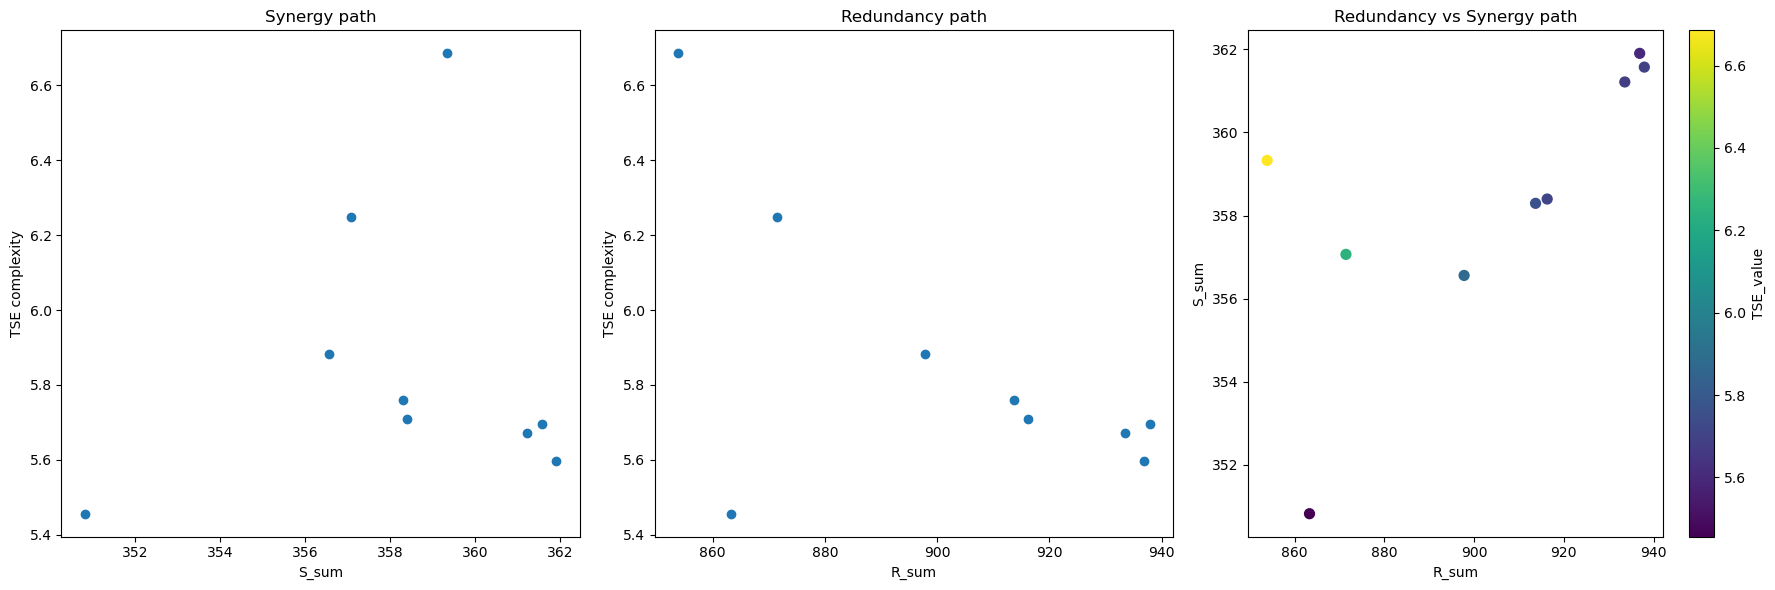

In [44]:
# Create a figure with 1 row and 3 columns for subplots
df = df_oscillators
plt.figure(figsize=(18, 6))

# First subplot for Synergy path
plt.subplot(1, 3, 1)  # (rows, columns, index)
plt.scatter(df['S_sum'], df['TSE_value'])
plt.xlabel('S_sum')
plt.ylabel('TSE complexity')
plt.title('Synergy path')

# Second subplot for Redundancy path
plt.subplot(1, 3, 2)
plt.scatter(df['R_sum'], df['TSE_value'])
plt.xlabel('R_sum')
plt.ylabel('TSE complexity')
plt.title('Redundancy path')

# Third subplot for Redundancy vs Synergy path
plt.subplot(1, 3, 3)
plt.scatter(df['R_sum'], df['S_sum'], c=df['TSE_value'], cmap='viridis', s=50)
plt.colorbar(label='TSE_value')
plt.xlabel('R_sum')
plt.ylabel('S_sum')
plt.title('Redundancy vs Synergy path')

# Adjust layout to avoid overlap and display the plot
#plt.suptitle(f'TSE dependence on R and S for windowsize:{window_size} and stepsize:{window_step} with maxD:{dimension_max} and totD:{dimension_tot}')
plt.tight_layout()
plt.show()

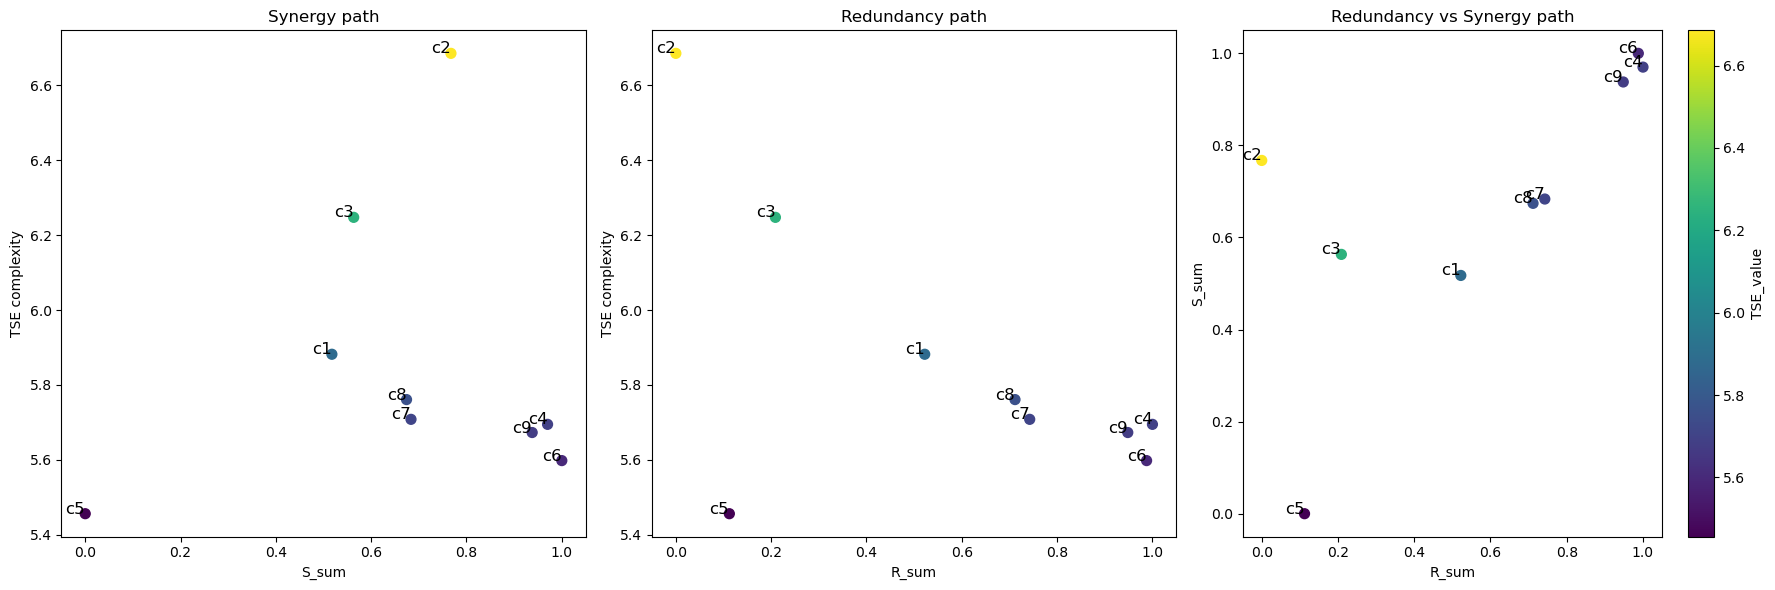

In [40]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 3 columns for subplots
df = df_oscillators
plt.figure(figsize=(18, 6))

# First subplot for Synergy path
plt.subplot(1, 3, 1)
plt.scatter(df['S_sum'], df['TSE_value'], c=df['TSE_value'], cmap='viridis', s=50)
for i, (x, y) in enumerate(zip(df['S_sum'], df['TSE_value']), 1):
    plt.text(x, y, f'c{i}', fontsize=12, ha='right')
plt.xlabel('S_sum')
plt.ylabel('TSE complexity')
plt.title('Synergy path')

# Second subplot for Redundancy path
plt.subplot(1, 3, 2)
plt.scatter(df['R_sum'], df['TSE_value'], c=df['TSE_value'], cmap='viridis', s=50)
for i, (x, y) in enumerate(zip(df['R_sum'], df['TSE_value']), 1):
    plt.text(x, y, f'c{i}', fontsize=12, ha='right')
plt.xlabel('R_sum')
plt.ylabel('TSE complexity')
plt.title('Redundancy path')

# Third subplot for Redundancy vs Synergy path
plt.subplot(1, 3, 3)
plt.scatter(df['R_sum'], df['S_sum'], c=df['TSE_value'], cmap='viridis', s=50)
for i, (x, y) in enumerate(zip(df['R_sum'], df['S_sum']), 1):
    plt.text(x, y, f'c{i}', fontsize=12, ha='right')
plt.colorbar(label='TSE_value')
plt.xlabel('R_sum')
plt.ylabel('S_sum')
plt.title('Redundancy vs Synergy path')

# Adjust layout to avoid overlap and display the plot
plt.tight_layout()
plt.show()


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def kuramoto(t, theta, omega, K, N):
    """Kuramoto model differential equation"""
    dtheta = np.zeros(N)
    for i in range(N):
        interaction = np.sum(np.sin(theta - theta[i]))
        dtheta[i] = omega[i] + (K / N) * interaction
    return dtheta

def simulate_kuramoto(N=5, K=1.0, T=10, dt=0.01):
    """Simulate the Kuramoto model and save frequency time series"""
    # Initialize random natural frequencies and initial phases
    omega = np.random.normal(loc=0, scale=1, size=N)
    initial_phases = np.random.uniform(0, 2 * np.pi, N)
    
    # Time vector
    t_eval = np.arange(0, T, dt)
    
    # Solve the system
    sol = solve_ivp(kuramoto, [0, T], initial_phases, args=(omega, K, N), t_eval=t_eval, method='RK45')
    
    # Compute instantaneous frequencies (time derivative of phases)
    frequencies = np.gradient(sol.y, sol.t, axis=1)
    
    return sol, omega, frequencies

# Example usage
N = 50  # Number of oscillators
K = 3  # Coupling strength
T = 100  # Duration of simulation in seconds
dt = 0.01  # Time step

sol, omega, frequencies = simulate_kuramoto(N=N, K=K, T=T, dt=dt)


In [5]:
frequencies_df = pd.DataFrame(frequencies)
frequencies_df = frequencies_df.transpose()

In [6]:
window_size = 1000
window_step = 10
dimension_max = 4
dimension_tot = 8

df_oscillators = interactions_values_relative(frequencies_df, window_size, window_step, dimension_max, dimension_tot)

C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\1310878519.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


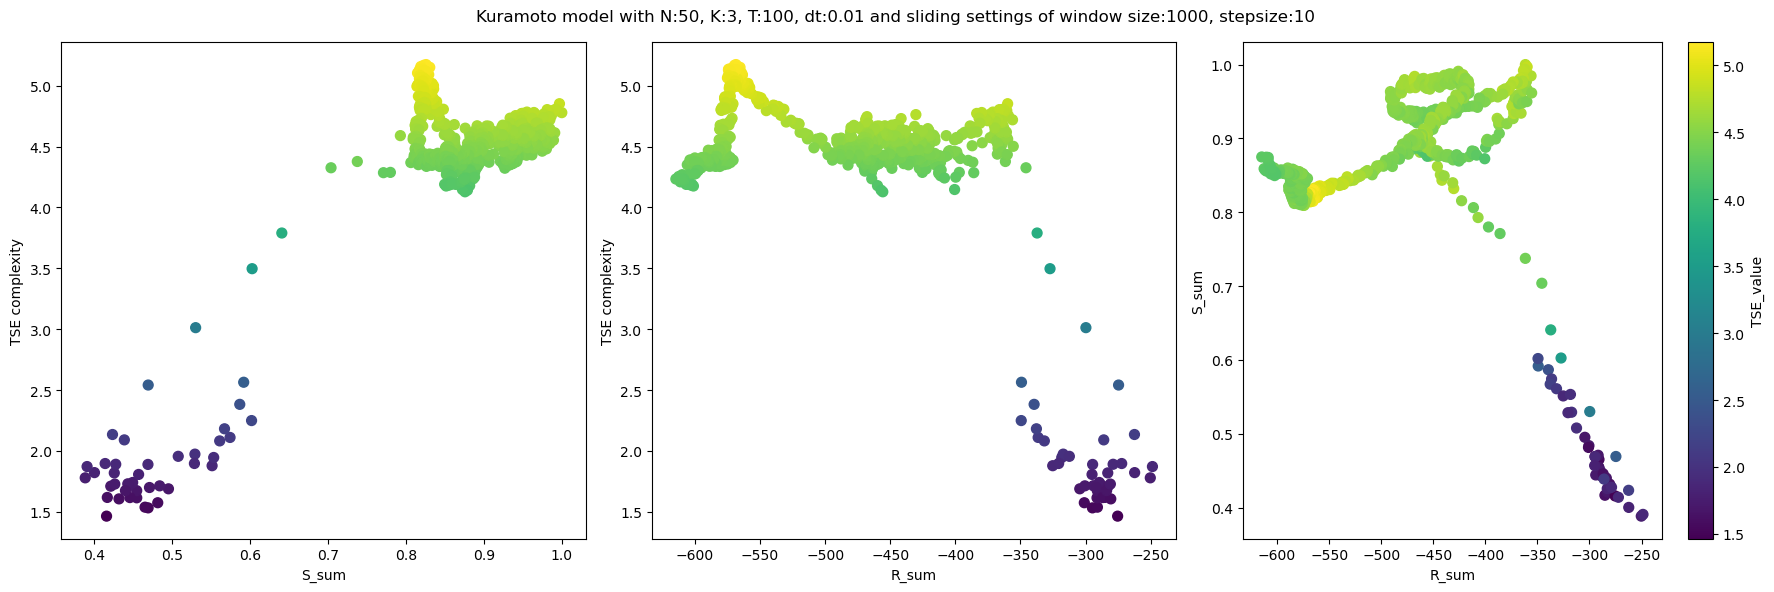

In [7]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 3 columns for subplots
df = df_oscillators
plt.figure(figsize=(18, 6))

# First subplot for Synergy path
plt.subplot(1, 3, 1)
plt.scatter(df['S_sum'], df['TSE_value'], c=df['TSE_value'], cmap='viridis', s=50)
# for i, (x, y) in enumerate(zip(df['S_sum'], df['TSE_value']), 1):
#    plt.text(x, y, f'c{i}', fontsize=12, ha='right')
plt.xlabel('S_sum')
plt.ylabel('TSE complexity')

# Second subplot for Redundancy path
plt.subplot(1, 3, 2)
plt.scatter(df['R_sum'], df['TSE_value'], c=df['TSE_value'], cmap='viridis', s=50)
#for i, (x, y) in enumerate(zip(df['R_sum'], df['TSE_value']), 1):
#    plt.text(x, y, f'c{i}', fontsize=12, ha='right')
plt.xlabel('R_sum')
plt.ylabel('TSE complexity')

# Third subplot for Redundancy vs Synergy path
plt.subplot(1, 3, 3)
plt.scatter(df['R_sum'], df['S_sum'], c=df['TSE_value'], cmap='viridis', s=50)
#for i, (x, y) in enumerate(zip(df['R_sum'], df['S_sum']), 1):
#    plt.text(x, y, f'c{i}', fontsize=12, ha='right')
plt.colorbar(label='TSE_value')
plt.xlabel('R_sum')
plt.ylabel('S_sum')

# Adjust layout to avoid overlap and display the plot
plt.suptitle(f'Kuramoto model with N:{N}, K:{K}, T:{T}, dt:{dt} and sliding settings of window size:{window_size}, stepsize:{window_step}')
plt.tight_layout()
plt.show()


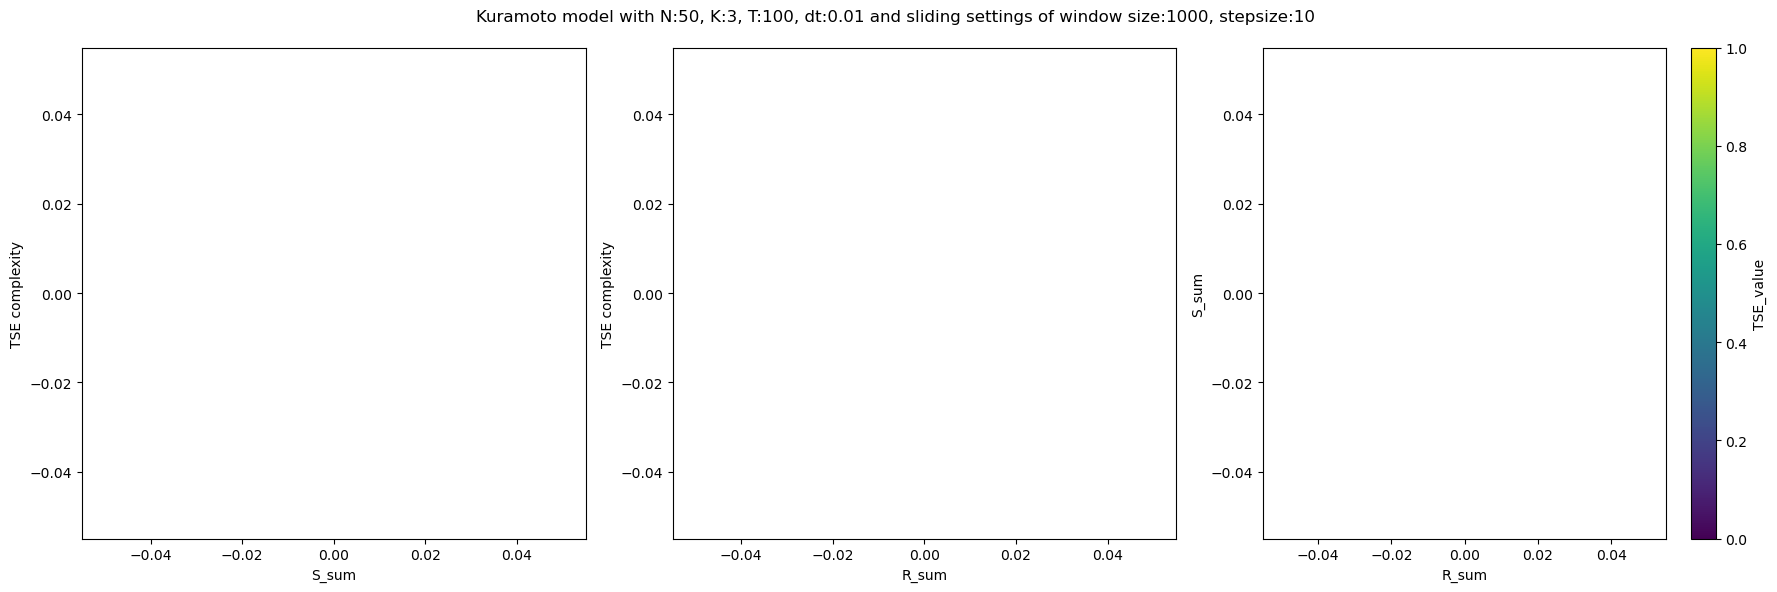

In [8]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Create a figure with 1 row and 3 columns for subplots
df = df_oscillators[:100]  # Ensure df_oscillators is defined
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Unpack the subplots
ax1, ax2, ax3 = axes

# Scatter plots with empty data, to be updated in animation
sc1 = ax1.scatter([], [], c=[], cmap='viridis', s=50)
sc2 = ax2.scatter([], [], c=[], cmap='viridis', s=50)
sc3 = ax3.scatter([], [], c=[], cmap='viridis', s=50)

# Set labels
ax1.set_xlabel('S_sum')
ax1.set_ylabel('TSE complexity')
ax2.set_xlabel('R_sum')
ax2.set_ylabel('TSE complexity')
ax3.set_xlabel('R_sum')
ax3.set_ylabel('S_sum')

# Add colorbar
cbar = fig.colorbar(sc3, ax=ax3, label='TSE_value')

# Title
fig.suptitle(f'Kuramoto model with N:{N}, K:{K}, T:{T}, dt:{dt} and sliding settings of window size:{window_size}, stepsize:{window_step}')
plt.tight_layout()

# Function to update the scatter plots
def update(i):
    # Update data for all subplots based on index i
    x1, y1, c1 = df['S_sum'][i], df['TSE_value'][i], df['TSE_value'][i]
    x2, y2, c2 = df['R_sum'][i], df['TSE_value'][i], df['TSE_value'][i]
    x3, y3, c3 = df['R_sum'][i], df['S_sum'][i], df['TSE_value'][i]

    # Update scatter plot data
    sc1.set_offsets(np.c_[[x1], [y1]])
    sc2.set_offsets(np.c_[[x2], [y2]])
    sc3.set_offsets(np.c_[[x3], [y3]])

    # Update colors
    sc1.set_array(np.array([c1]))
    sc2.set_array(np.array([c2]))
    sc3.set_array(np.array([c3]))

    return sc1, sc2, sc3

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(df), interval=500, blit=True)

# Save as GIF
ani.save('Figures\\TSE_kuramoto.gif', writer=animation.PillowWriter(fps=2))

plt.show()